Epoch 1/50
32/32 [==============================] - 35s 1s/step - loss: 0.9874 - accuracy: 0.4608 - val_loss: 0.8930 - val_accuracy: 0.4414 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 33s 1s/step - loss: 0.9650 - accuracy: 0.4548 - val_loss: 0.8832 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 32s 1s/step - loss: 0.9718 - accuracy: 0.4639 - val_loss: 0.8658 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 32s 998ms/step - loss: 0.9088 - accuracy: 0.5763 - val_loss: 0.8445 - val_accuracy: 0.6036 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 32s 1s/step - loss: 0.9374 - accuracy: 0.5311 - val_loss: 0.8717 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 32s 1s/step - loss: 0.8559 - accuracy: 0.6325 - val_loss: 0.8515 - val_accuracy: 0.5766 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 33s 1s/step - loss: 0.8364 

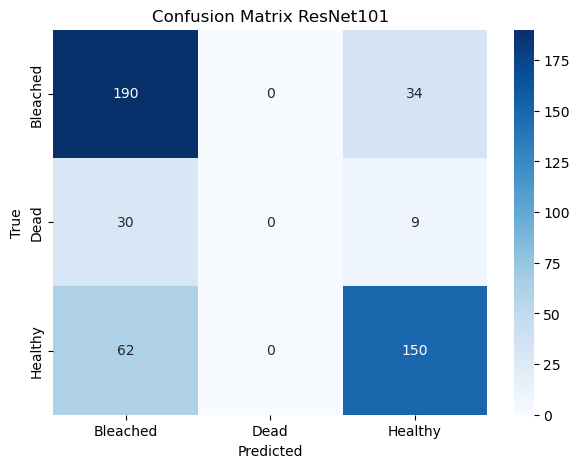

              precision    recall  f1-score   support

    Bleached       0.67      0.85      0.75       224
        Dead       0.00      0.00      0.00        39
     Healthy       0.78      0.71      0.74       212

    accuracy                           0.72       475
   macro avg       0.48      0.52      0.50       475
weighted avg       0.66      0.72      0.68       475



E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


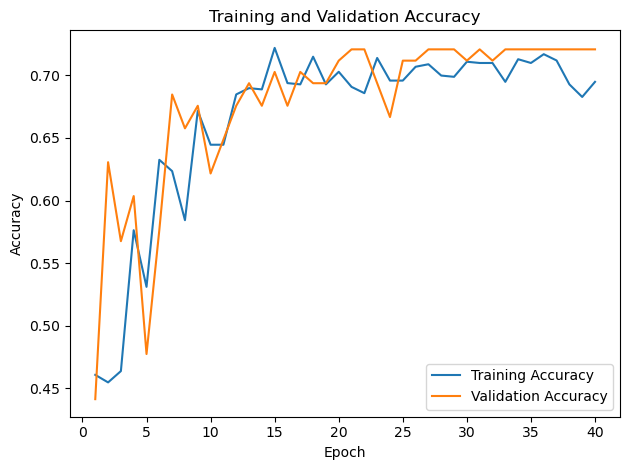

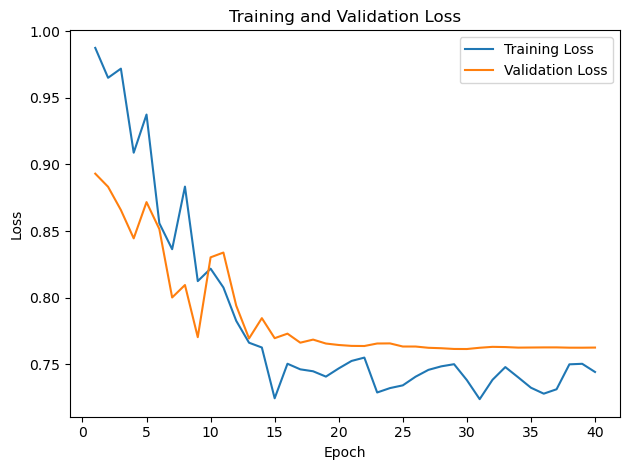

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50 # Change the import statement
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create and compile the model with ResNet101
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))  # Change the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(len(Categories), activation='softmax')  # Update the number of output classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", np.mean(y_pred_labels == y_true_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix ResNet101')  # Update the title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

Epoch 1/50
32/32 [==============================] - 40s 1s/step - loss: 0.6234 - accuracy: 0.7400 - val_loss: 0.4786 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 35s 1s/step - loss: 0.3782 - accuracy: 0.8464 - val_loss: 0.2984 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 35s 1s/step - loss: 0.3107 - accuracy: 0.8755 - val_loss: 0.2480 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 35s 1s/step - loss: 0.2751 - accuracy: 0.8865 - val_loss: 0.2545 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 36s 1s/step - loss: 0.2521 - accuracy: 0.8896 - val_loss: 0.2809 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 35s 1s/step - loss: 0.2992 - accuracy: 0.8835 - val_loss: 0.4226 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 35s 1s/step - loss: 0.2153 - a

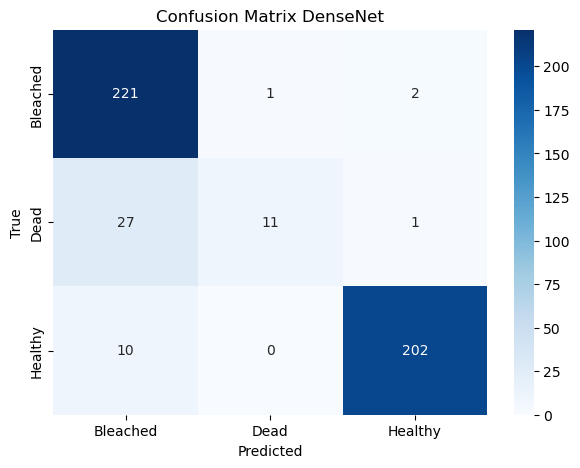

              precision    recall  f1-score   support

    Bleached       0.86      0.99      0.92       224
        Dead       0.92      0.28      0.43        39
     Healthy       0.99      0.95      0.97       212

    accuracy                           0.91       475
   macro avg       0.92      0.74      0.77       475
weighted avg       0.92      0.91      0.90       475



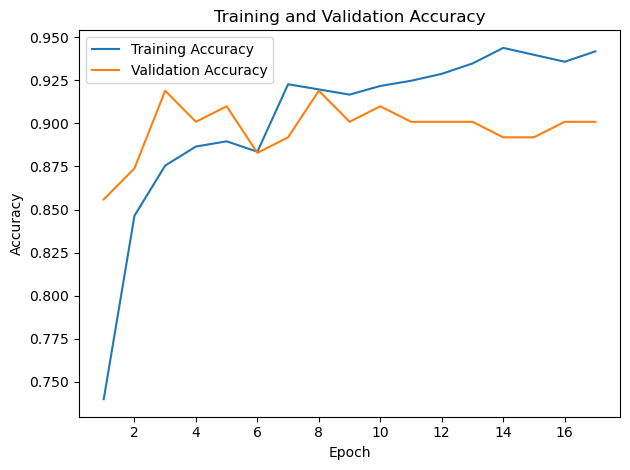

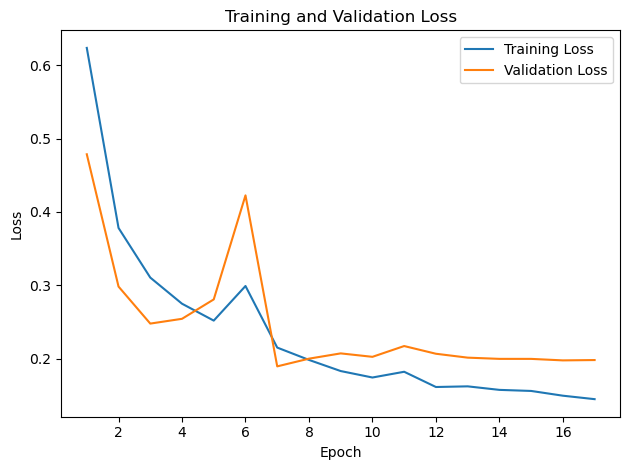

E:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224  # Adjust the image size based on DenseNet's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix DenseNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

# Save the trained model
model.save("DenseNet_TerumbuKarang1.h5")

Epoch 1/50
32/32 [==============================] - 16s 451ms/step - loss: 0.6184 - accuracy: 0.7871 - val_loss: 0.4791 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 14s 447ms/step - loss: 0.3751 - accuracy: 0.8404 - val_loss: 0.2821 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 14s 443ms/step - loss: 0.3438 - accuracy: 0.8604 - val_loss: 0.2488 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 14s 428ms/step - loss: 0.2653 - accuracy: 0.8956 - val_loss: 0.2620 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 14s 423ms/step - loss: 0.2583 - accuracy: 0.8876 - val_loss: 0.2116 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 14s 429ms/step - loss: 0.2172 - accuracy: 0.9137 - val_loss: 0.1598 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 14s 453ms/st

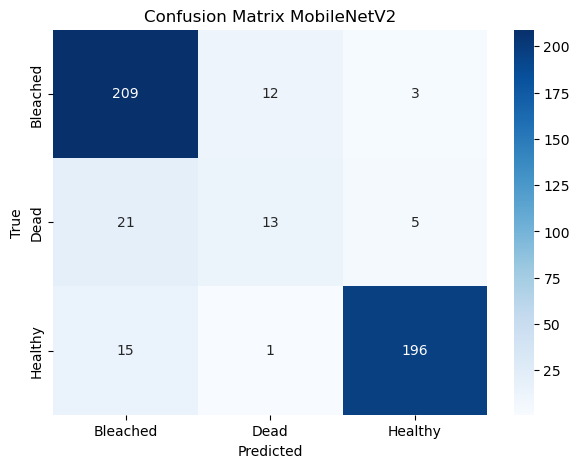

              precision    recall  f1-score   support

    Bleached       0.85      0.93      0.89       224
        Dead       0.50      0.33      0.40        39
     Healthy       0.96      0.92      0.94       212

    accuracy                           0.88       475
   macro avg       0.77      0.73      0.74       475
weighted avg       0.87      0.88      0.87       475



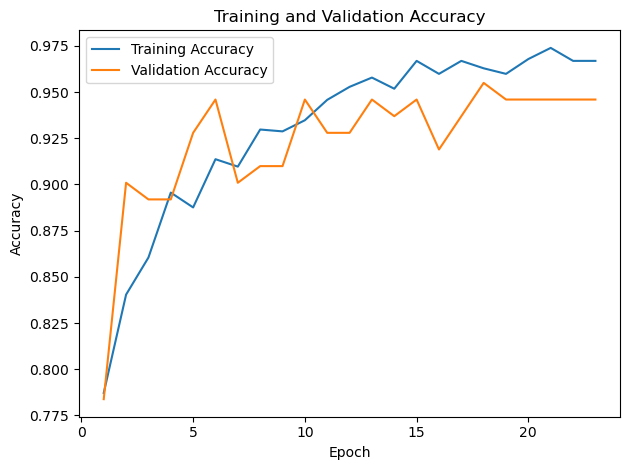

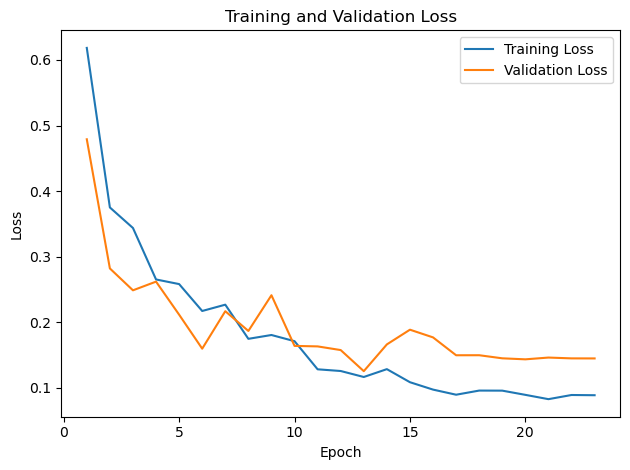

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224  # Adjust the image size based on MobileNetV2's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(Categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

Epoch 1/50
32/32 [==============================] - 114s 3s/step - loss: 0.7575 - accuracy: 0.7159 - val_loss: 1.0923 - val_accuracy: 0.5946 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 99s 3s/step - loss: 0.5237 - accuracy: 0.7882 - val_loss: 0.6171 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 99s 3s/step - loss: 0.4334 - accuracy: 0.8313 - val_loss: 0.5643 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 97s 3s/step - loss: 0.4040 - accuracy: 0.8484 - val_loss: 0.5499 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 94s 3s/step - loss: 0.3815 - accuracy: 0.8504 - val_loss: 0.7768 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 92s 3s/step - loss: 0.4037 - accuracy: 0.8343 - val_loss: 0.5037 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 93s 3s/step - loss: 0.3261 - 

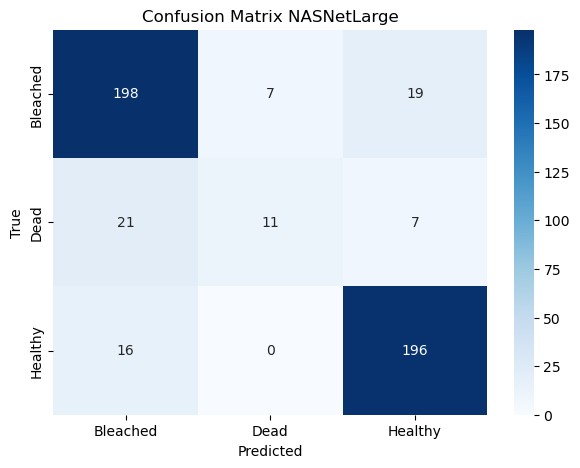

              precision    recall  f1-score   support

    Bleached       0.84      0.88      0.86       224
        Dead       0.61      0.28      0.39        39
     Healthy       0.88      0.92      0.90       212

    accuracy                           0.85       475
   macro avg       0.78      0.70      0.72       475
weighted avg       0.84      0.85      0.84       475



C:\Users\USER\AppData\Local\Temp\ipykernel_9324\1073843300.py:129: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


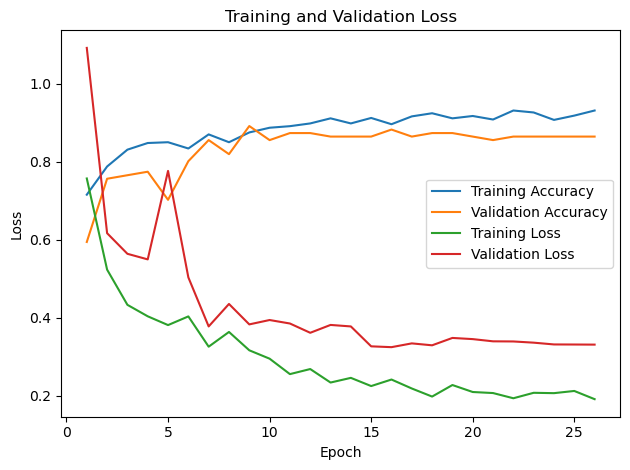

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset"
Categories = ["Bleached", "Dead", "Healthy"]

img_size = 224

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create and compile the model with NASNetLarge
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", np.mean(y_pred_labels == y_true_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix NASNetLarge')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()
